In [1]:
import os
import csv
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

import matplotlib
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
### REPLACE with path to AnnData downloaded from GCP ###
data_dir = '/Users/adaly/Documents/mouse_colon/csplotch_anndata'
adata = sc.read_h5ad(os.path.join(data_dir, 'adata_csplotch_lambdas.h5ad'))

In [11]:
age_str = '12w'
df_bayes_crypt = pd.read_csv('../data/fig4_bayes_factors_crypt_gradient_12w.csv')

# Read in mapping of ENSEMBL to common
df_map = pd.read_csv('../data/Gene_names_mm.txt', sep='_', header=None, names=['common'])
df_bayes_crypt = df_bayes_crypt.join(df_map, how='left', on='gene')

### Fig. 4f: heatmap visualization of gradient genes

In [8]:
# Specify a color mapping between gene functional annotations and colors:
broad_fun_colors = {
    'Extracellular matrix': matplotlib.cm.get_cmap('tab20')(0.70),
    'Cell polarity and cytoskeleton': matplotlib.cm.get_cmap('tab20')(0.75),
    'Ion transport': matplotlib.cm.get_cmap('tab20')(0.2),
    'Oxireductase activity': matplotlib.cm.get_cmap('tab20')(0.25),
    'Ribosome and protein translation': matplotlib.cm.get_cmap('tab20')(0.4),
    'RNA binding and processing': matplotlib.cm.get_cmap('tab20')(0.45),
    'DNA replication': matplotlib.cm.get_cmap('tab20')(0.5),
    'DNA repair': matplotlib.cm.get_cmap('tab20')(0.55),
}

bold_genes = ['Reln', 'Fgfr2', 'Msh2', 'Ezr', 'Gpa33', 'Krt8', 'Ceacam1']

In [5]:
def grad_gene_heatmap(df_bayes, region='any', age_str='12w', highlight_genes=None, gene_functions=None,
                      bold_genes=None,
                      xlabels=True, cbar_pos=(0.02, 0.8, 0.05, 0.18)):
    
    regions_ordered = ['Proximal', 'Middle', 'Distal']
    aars_ordered = ['mean_subcrypt', 'mean_base', 'mean_mid', 'mean_apex']
    
    # genes with gradient behavior in any region (union)
    if region == 'any':
        grad_genes_any = df_bayes['common'][df_bayes['grad_gene']].unique()
        inds_grad = df_bayes['common'].isin(grad_genes_any)
        
    # genes with gradient behavior in all regions (intersection)
    elif region == 'all':
        grad_genes_all = df_bayes['common'].unique()
        for r in regions_ordered:
            inds_grad_r = np.logical_and(df_bayes['grad_gene'], df_bayes['Region']==r)
            grad_genes_r = df_bayes['common'][inds_grad_r].values
            grad_genes_all = np.intersect1d(grad_genes_r, grad_genes_all)

        inds_grad = df_bayes['common'].isin(grad_genes_all)
    
    # genes with gradient behavior in a single region
    else:
        inds_grad = np.logical_and(df_bayes['grad_gene'], df_bayes['Region']==region)
    
    
    # Include AARs from all regions
    if region == 'any' or region == 'all':
        df_mean_betas = None
        
        for r in regions_ordered:
            inds_grad_in = np.logical_and(inds_grad, df_bayes['Region']==r)
            
            df_mean_betas_r = df_bayes.loc[inds_grad_in][aars_ordered]
            df_mean_betas_r.index = df_bayes['common'][inds_grad_in]
            df_mean_betas_r.columns = ['%s %s' % (r, a) for a in aars_ordered]
            
            if df_mean_betas is None:
                df_mean_betas = df_mean_betas_r
            else:
                df_mean_betas = df_mean_betas.join(df_mean_betas_r, how='outer')
                            
        # reorder columns
        c_order = []
        for a in aars_ordered:
            for r in regions_ordered:
                c_order.append('%s %s' % (r, a))
        df_mean_betas = df_mean_betas[c_order]
                
    # Include only AARs from specified region
    else:
        df_mean_betas = df_bayes.loc[inds_grad][aars_ordered]
        df_mean_betas.index = df_bayes['common'][inds_grad]
    
    if len(df_mean_betas) == 0:
        print('No gradient genes found for region "%s"' % region)
        return None
    
    # scale mean betas for each gene between 0 and 1 across AARs+regions
    df = df_mean_betas.T - df_mean_betas.T.min()
    df_mean_betas_scaled = (df / df.max()).T
    
    # if gene functions provided, color rows accordingly:
    if gene_functions is not None:
        row_colors = []
        for g in df_mean_betas_scaled.index:
            if g in gene_functions.index:
                row_colors.append(broad_fun_colors[gene_functions.loc[g]])
            else:
                row_colors.append((1,1,1,1))
        row_colors = pd.Series(index=df_mean_betas_scaled.index, data=row_colors)
 
    # create clustermap without dendrogram
    cg = sns.clustermap(data=df_mean_betas_scaled, 
                        metric='cityblock', method='average',
                        row_cluster=True, col_cluster=False,
                        row_colors=row_colors,
                        cbar_kws={'label':r'normalized mean $\beta$'},
                        cbar_pos=cbar_pos,
                        cmap = 'YlGnBu_r',
                        figsize=(6, 2 + 30 * len(df_mean_betas_scaled) / 321))
    cg.ax_row_dendrogram.set_visible(False)
    
    # legend for row colors
    if gene_functions is not None and (region == 'any' or region == 'all'):
        handles = [Patch(facecolor=broad_fun_colors[name]) for name in broad_fun_colors]
        plt.legend(handles, broad_fun_colors, title='Gene function',
           bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')
    
    # list of genes in the order they are plotted
    row_inds_ordered = cg.dendrogram_row.reordered_ind
    df_ordered = df_mean_betas_scaled.iloc[row_inds_ordered, :]
    
    if df_ordered.iloc[0,0] > df_ordered.iloc[-1,0]:
        cg.ax_heatmap.invert_yaxis()
        cg.ax_row_dendrogram.invert_yaxis()
        cg.ax_row_colors.invert_yaxis()
    
    if region == 'all':
        cg.ax_heatmap.set_title('All regions, %s (N=%d gradient genes)' % (age_str, len(df_mean_betas_scaled)))
    elif region == 'any':
        cg.ax_heatmap.set_title('Any region, %s (N=%d gradient genes)' % (age_str, len(df_mean_betas_scaled)))
    else:
        cg.ax_heatmap.set_title('%s, %s (N=%d gradient genes)' % (region, age_str, len(df_mean_betas_scaled)))
        
    # if specified, only label highlighted genes on y-axis
    if highlight_genes is not None:
        yticks, yticklabels = [],[]
        row_inds_ordered = cg.dendrogram_row.reordered_ind
        
        for y,g in enumerate(df_mean_betas_scaled.index[row_inds_ordered]):
            if g in highlight_genes:
                yticks.append(y)
                yticklabels.append(g)
        
        # Add leading spaces to densely clustered labels, in order to stagger them
        space_char = '  '
        for i, (y,g) in enumerate(zip(yticks, yticklabels)):
            if i>0 and yticks[i-1] == y-1 and not yticklabels[i-1].startswith(space_char):
                if yticks[i+1] == y+1:
                    spacer = space_char * np.maximum(len(yticklabels[i-1]), len(yticklabels[i+1]))
                else:
                    spacer = space_char * len(yticklabels[i-1])
                yticklabels[i] = spacer + g
        
        cg.ax_heatmap.set_yticks(yticks)
        cg.ax_heatmap.set_yticklabels(yticklabels, fontsize=9)
    
    # optionally, turn off x ticks/labels (for multi-row plots)
    if not xlabels:
        cg.ax_heatmap.set_xticks([])
        cg.ax_heatmap.set_xticklabels([])
    
    cg.ax_heatmap.set_ylabel('')
    
    # ensure y ticklabels are always horizontal and x ticklabels always vertical
    plt.setp(cg.ax_heatmap.get_yticklabels(), rotation=0)
    plt.setp(cg.ax_heatmap.get_xticklabels(), rotation=90) 
    
    # bold selected genes on y-axis
    if bold_genes is not None:
        for i, yl in enumerate(cg.ax_heatmap.get_yticklabels()):
            if yl.get_text().strip() in bold_genes:
                cg.ax_heatmap.get_yticklabels()[i].set_weight('bold')
    
    return cg, df_ordered

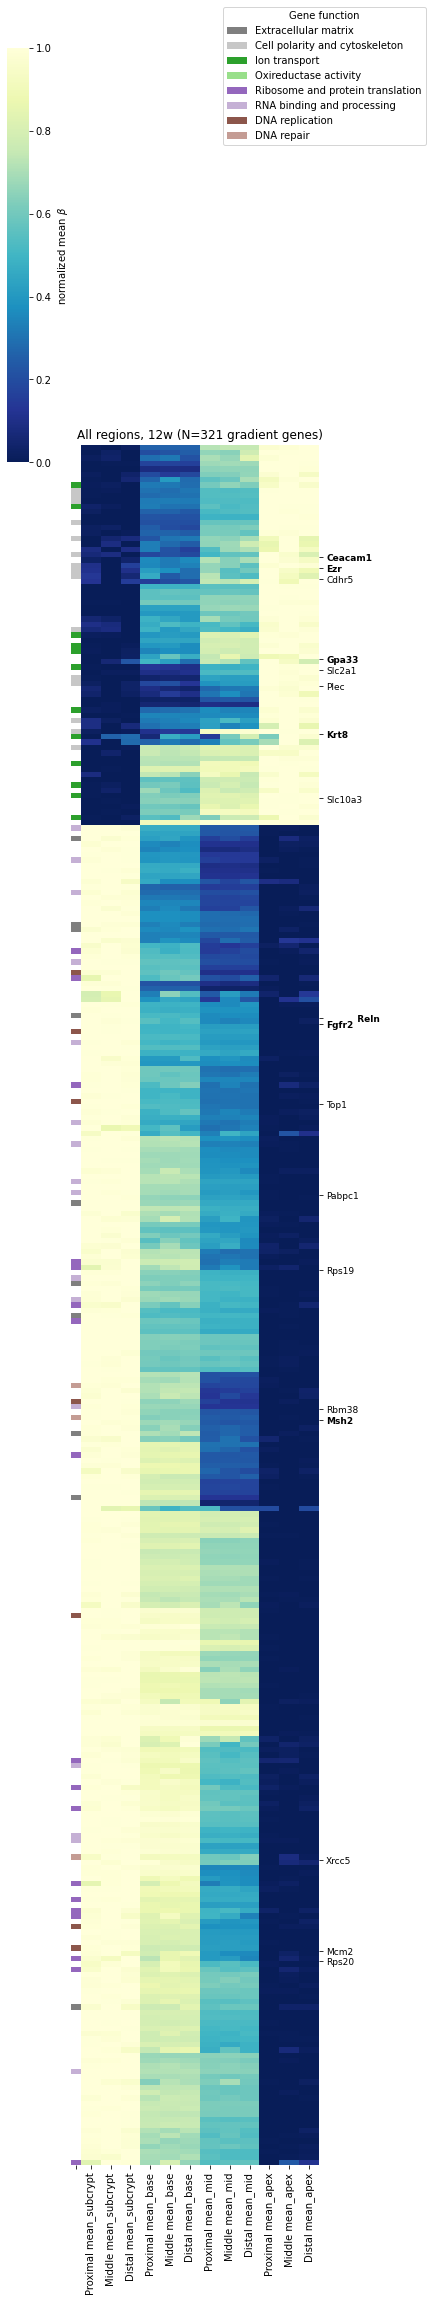

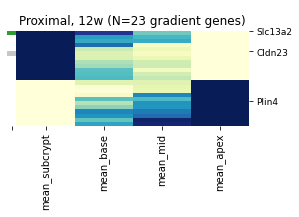

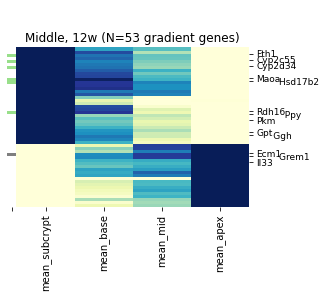

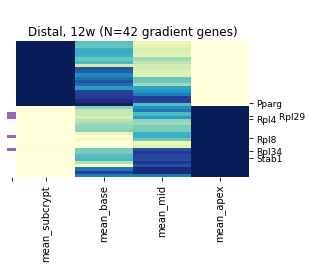

In [13]:
f_annot_file = '../data/fig4_gradient_genes_annotated_FC.txt'
df_annot = pd.read_csv(f_annot_file, header=0, index_col=0, sep='\t')

# genes mentioned in text
highlight_genes = ['Ceacam1', 'Ezr', 'Gpa33', 'Krt8', 'Reln', 'Fgfr2', 'Top1', 
                   'Mcm2', 'Msh2', 'Xrcc5', 'Rbm38', 'Pabpc1', 'Rps19', 'Rps20', 
                   'Cdhr5', 'Plec', 'Slc2a1', 'Slc10a3']

# Genes gradient across all colon regions
cg, df_all = grad_gene_heatmap(df_bayes_crypt, 'all', highlight_genes=highlight_genes, 
                               gene_functions=df_annot['Broad functional annotation'].dropna(), 
                               bold_genes=bold_genes)
plt.show()

# Genes exclusively gradient in each colon region
ex_grad_genes = []
for g in df_bayes_crypt['common'].unique():
    n_grad_reg = df_bayes_crypt[df_bayes_crypt['common']==g]['grad_gene'].sum()
    if n_grad_reg == 1:
        ex_grad_genes.append(g)
ex_grad_genes = np.array(ex_grad_genes)
df_bayes_crypt_ex = df_bayes_crypt[df_bayes_crypt['common'].isin(ex_grad_genes)]

for r in ['Proximal', 'Middle', 'Distal']:
    f_annot_file = '../data/fig4_gradient_genes_annotated_FC_%s.txt' % r
    df_annot = pd.read_csv(f_annot_file, header=0, index_col=0, sep='\t')

    cg, df_reg = grad_gene_heatmap(df_bayes_crypt_ex, r, highlight_genes=df_annot.index,
                                   gene_functions=df_annot['Broad functional annotation'].dropna(), 
                                   bold_genes=bold_genes,
                                   cbar_pos=None)
    plt.subplots_adjust(left=0.1, right=0.8, bottom=0.5, top=0.9)
    plt.show()